# Robots fight in Gridworld

We have an $n\times n$ grid with red and blue robots in each cell. The robots fight robots with different color and their strength subtracts the strength of their oponent after each fight. When a robot reaches 0 strength we flag it as "dead". Robots can only fight neighbours (the bottom can fight the top etc.). This is a deterministic model. For now I am not going to let the robots learn anything, they simply follow orders.

In [1]:
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GridWorld:
    def __init__(self, size, Robot):
        """Initialises the GridWorld object.

        Args:
            size: an integer number of rows and columns
        """
        self.size = size
        sides = range(size)
        self.coords = itertools.product(sides, sides)
        self.robots = {
            (x, y): Robot(x, y, self)
            for x, y in self.coords
        }

    def run(self, n_steps):
        """Runs the simulation of a number of time steps.

        Args:
            n_steps: an integer number of steps
        """
        for turn in range(n_steps):
            self.take_turn()

    def take_turn(self, print_det = True):
        """Move robots"""
        alive = [r for r in self.robots.values() if r.kind != 'dead']
        random.shuffle(alive)
        for r in alive:
            ax, ay = self.robots[(r.x,r.y)].choose_action()
            if (ax,ay) != (r.x,r.y):
                if print_det : print('fight: ', (r.x, r.y), "with", (ax,ay))
                self.robots[(r.x,r.y)].fight(self.robots[(ax,ay)])
                if print_det:
                    print('kind after fight: ', self.robots[(r.x,r.y)].kind, self.robots[(ax,ay)].kind)
                    print('strength after fight: ', self.robots[(r.x,r.y)].strength, self.robots[(ax,ay)].strength)
                    self.print_world()

    
    
    def print_world_img(self, ax=None):
        """Print the world as an interpolated image"""
        dict_code = {'red':1, 'blue': -1, 'dead':0}
        U = [dict_code[r.kind] for r in self.robots.values()]
        U = np.reshape(U, (-1, self.size))
        
        ax.imshow(U, cmap=plt.get_cmap('seismic'),
                  interpolation='bilinear',
                  extent=[-1, 1, -1, 1])
        ax.set_axis_off()
        
    
    def print_world(self):
        """For small worlds print the world as a table"""
        for i in range(self.size):
            print('-----------------')
            out = '| '
            for j in range(self.size):
                if self.robots[(i,j)].kind == 'blue' :
                    token = 'b_' + str(self.robots[(i,j)].strength)
                if self.robots[(i,j)].kind == 'red':
                    token = 'r_' + str(self.robots[(i,j)].strength)
                if self.robots[(i,j)].kind == 'dead':
                    token = '0'
                out += token + ' | '
            print(out)
        print('-----------------')  
        
    def report_stat(self):
        """Report statistics"""
        all_kinds = np.array([r.kind for r in self.robots.values()])
        
        (unique, counts) = np.unique(all_kinds, return_counts=True)
        n = len(unique)
        frequencies = {unique[i]:counts[i] for i in range(n)}
        return frequencies
        

In [3]:
class Robot:
    def __init__(self, x, y, world):
        """Initialises the Robot object.

        Args:
            x: the integer x-coordinate
            y: the integer y-coordinate
            world: an instance of the GridWorld class
        """
        self.x = x
        self.y = y
        self.kind = random.choice(["red", "blue"])
        self.strength = random.randint(1,10)
        self.world = world

    
    
    def choose_action(self):
        """Find which robot neighbour to attack if any
        Returns: new position tuple coordinates
        
        """
        min_strength = self.strength
        min_x, min_y = self.x, self.y
        for x, y in itertools.product([-1, 0, 1], [-1, 0, 1]):
            ax = (self.x + x) % self.world.size
            ay = (self.y + y) % self.world.size
            
            c1 = self.world.robots[ax, ay].strength <= min_strength
            c2 = self.world.robots[ax, ay].kind != self.kind
            c3 = self.world.robots[ax, ay].kind != 'dead'
            if (c1) & (c2) & (c3):
                min_x, min_y = ax, ay
        
        return min_x, min_y
    

    def fight(self, robot):
        """Make robots fight
        Args:
            robot: the robot object to fight with
        
        """
        result = self.strength - robot.strength
        if result > 0:
            robot.kind = self.kind
            self.kind = 'dead'
            self.strength = 0 
            robot.strength = result
        elif result == 0:
            self.kind = 'dead'
            robot.kind = 'dead'
            robot.strength = 0
            self.strength = 0
    

In [4]:
tiny_world = GridWorld(3, Robot)

In [5]:
tiny_world.print_world()

-----------------
| b_1 | b_2 | b_3 | 
-----------------
| b_8 | b_9 | b_3 | 
-----------------
| r_5 | r_9 | b_3 | 
-----------------


In [6]:
tiny_world.take_turn()

fight:  (2, 1) with (0, 2)
kind after fight:  dead red
strength after fight:  0 6
-----------------
| b_1 | b_2 | r_6 | 
-----------------
| b_8 | b_9 | b_3 | 
-----------------
| r_5 | 0 | b_3 | 
-----------------
fight:  (1, 1) with (2, 0)
kind after fight:  dead blue
strength after fight:  0 4
-----------------
| b_1 | b_2 | r_6 | 
-----------------
| b_8 | 0 | b_3 | 
-----------------
| b_4 | 0 | b_3 | 
-----------------
fight:  (1, 0) with (0, 2)
kind after fight:  dead blue
strength after fight:  0 2
-----------------
| b_1 | b_2 | b_2 | 
-----------------
| 0 | 0 | b_3 | 
-----------------
| b_4 | 0 | b_3 | 
-----------------


## Let's scale it up

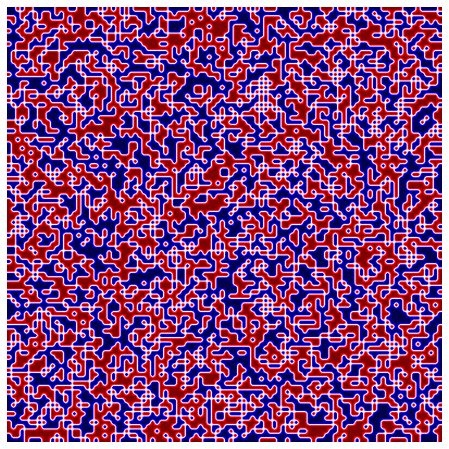

In [7]:
size = 100
big_world = GridWorld(size, Robot)
fig, axes = plt.subplots(1,1, figsize=(15, 8))
big_world.print_world_img(ax=axes)

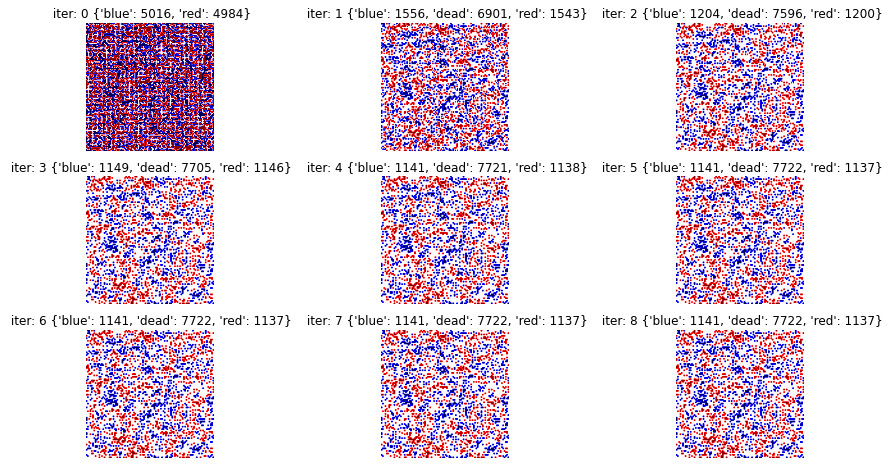

In [8]:
n=10
fig, axes = plt.subplots(3, 3, figsize=(15, 8))
step_plot = n // 9

for i in range(n):
    if i % step_plot == 0 and i < 9 * step_plot:
        ax = axes.flat[i // step_plot]
        big_world.print_world_img(ax=ax)
        freqs = big_world.report_stat()
        ax.set_title(" iter: "+ str(i)+ " " + str(freqs))
    big_world.take_turn(print_det = False)

## Equilibrium and robot reprograming

It is reaching an equilibrium pretty fast. The robots probably killed all their neighbours and they have no incentive to travel to kill more. I was hoping to see some segregation like in Schelling's model or in FitzHugh–Nagumo equation (see differential equations) that showcases Turing patterns. This equation however is a reaction diffusion equation, where the reaction is the transformation of one "robot" to another (not to mention the spatial diffusion). So I am going to reprogram our robots. There will be no dead robots and their strength will not reduce after each fight.

In [9]:
class Robot2:
    def __init__(self, x, y, world):
        """Initialises the Robot object.

        Args:
            x: the integer x-coordinate
            y: the integer y-coordinate
            world: an instance of the GridWorld class
        """
        self.x = x
        self.y = y
        self.kind = random.choice(["red", "blue"])
        self.strength = random.randint(1,10)
        self.world = world

    
    
    def choose_action(self):
        """Find which robot neighbour to attack if any
        Returns: new position tuple coordinates
        
        """
        min_strength = self.strength
        min_x, min_y = self.x, self.y
        for x, y in itertools.product([-1, 0, 1], [-1, 0, 1]):
            ax = (self.x + x) % self.world.size
            ay = (self.y + y) % self.world.size
            
            c1 = self.world.robots[ax, ay].strength <= min_strength
            c2 = self.world.robots[ax, ay].kind != self.kind
            if (c1) & (c2):
                min_x, min_y = ax, ay
        
        return min_x, min_y
    

    def fight(self, robot):
        """Make robots fight
        Args:
            robot: the robot object to fight with
        
        """
        result = self.strength - robot.strength
        if result > 0:
            robot.kind = self.kind
    

In [10]:
tiny_world2 = GridWorld(3, Robot2)
tiny_world2.print_world()
tiny_world2.take_turn()

-----------------
| b_5 | r_10 | b_2 | 
-----------------
| b_8 | r_2 | b_7 | 
-----------------
| r_3 | b_1 | r_6 | 
-----------------
fight:  (1, 2) with (2, 0)
kind after fight:  blue blue
strength after fight:  7 3
-----------------
| b_5 | r_10 | b_2 | 
-----------------
| b_8 | r_2 | b_7 | 
-----------------
| b_3 | b_1 | r_6 | 
-----------------
fight:  (0, 1) with (1, 2)
kind after fight:  red red
strength after fight:  10 7
-----------------
| b_5 | r_10 | b_2 | 
-----------------
| b_8 | r_2 | r_7 | 
-----------------
| b_3 | b_1 | r_6 | 
-----------------
fight:  (0, 2) with (1, 1)
kind after fight:  blue red
strength after fight:  2 2
-----------------
| b_5 | r_10 | b_2 | 
-----------------
| b_8 | r_2 | r_7 | 
-----------------
| b_3 | b_1 | r_6 | 
-----------------
fight:  (2, 2) with (0, 0)
kind after fight:  red red
strength after fight:  6 5
-----------------
| r_5 | r_10 | b_2 | 
-----------------
| b_8 | r_2 | r_7 | 
-----------------
| b_3 | b_1 | r_6 | 
----------

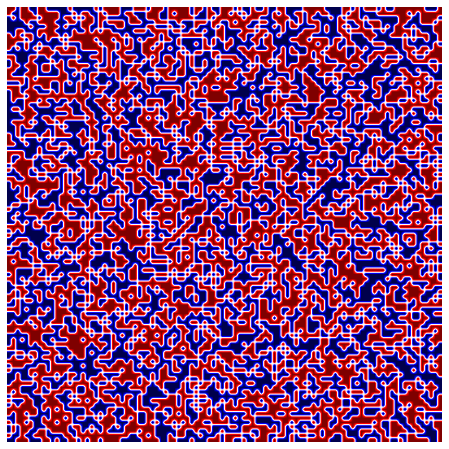

In [13]:
size = 100
big_world2 = GridWorld(size, Robot2)
fig, axes = plt.subplots(1,1, figsize=(15, 8))
big_world2.print_world_img(ax=axes)

# Voilà

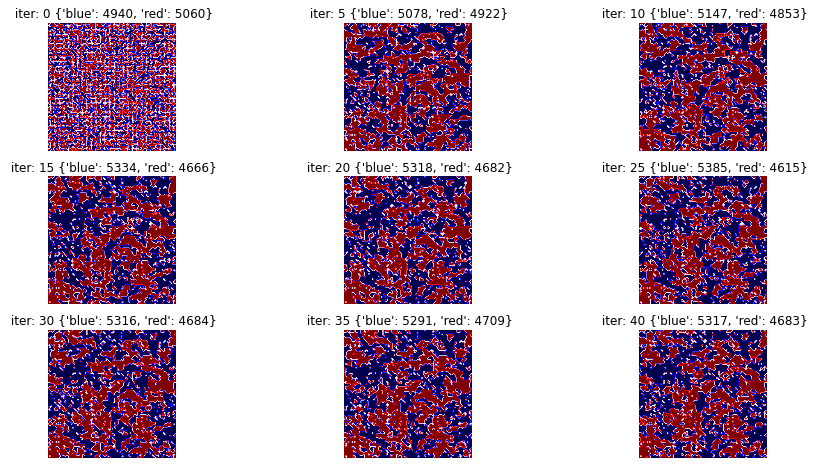

In [14]:
n=50
fig, axes = plt.subplots(3, 3, figsize=(15, 8))
step_plot = n // 9

for i in range(n):
    if i % step_plot == 0 and i < 9 * step_plot:
        ax = axes.flat[i // step_plot]
        big_world2.print_world_img(ax=ax)
        freqs = big_world2.report_stat()
        ax.set_title(" iter: "+ str(i)+ " " + str(freqs))
    big_world2.take_turn(print_det = False)

The pattern seems to become stable in a macrolevel but in a microlevel there are still small changes. An interesting question is wether there can be a small change in a microlevel which changes the final pattern above significantly